In [74]:
printmd('PYTORCH based Video and Image object detecting with pre-trained model')
printmd('FasterRCNN with ResNet50 pretrained model and FastRCNN Predictor used for classification.')
printmd('Trained until mAP value of 80% achieved; 120 Images and Masks used to train and 50 to test')
printmd('5 videos and 5 Images used here for demostration')


## <span style="color:#116611">PYTORCH based Video and Image object detecting with pre-trained model</span>

## <span style="color:#116611">FasterRCNN with ResNet50 pretrained model and FastRCNN Predictor used for classification.</span>

## <span style="color:#116611">Trained until mAP value of 80% achieved; 120 Images and Masks used to train and 50 to test</span>

## <span style="color:#116611">5 videos and 5 Images used here for demostration</span>

In [65]:
################################################################################################################################
# import required libraries torch, torchvision, PIL, CV2 etc.
################################################################################################################################
import os
import numpy as np
import torch
from PIL import Image

import transforms as T
import utils, engine
import torchvision
from IPython.display import clear_output
%pylab inline 

import cv2
import tqdm 
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('## <span style="color:#116611">'+string+'</span>'))

Populating the interactive namespace from numpy and matplotlib


In [2]:
################################################################################################################################
# define PennFudanDataset dataset class with Images and Masks, bounding box coordinates for each mask taken from it
# and also define target features
################################################################################################################################
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):     
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
        mask = Image.open(mask_path)
        
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            
            pos = np.where(masks[i])  
            
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
    
       # masks = torch.as_tensor(masks, dtype=torch.int64)

        image_id = torch.tensor([idx])
    
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"]    = boxes
        target["labels"]   = labels
        target["masks"]    = masks
        target["image_id"] = image_id
        target["area"]     = area
        target["iscrowd"]  = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
    
        return len(self.imgs)

In [67]:
printmd('Model instantiation')

## <span style="color:#116611">Model instantiation</span>

In [3]:
################################################################################################################################
# import the FASTER RCNN , MASK RCNN Predictors and the pretrained MASK RCNN RESNET50 model
# load the instance segmentation model pre-trained on COCO
# get number of input features for the classifier
# replace the pre-trained head with a new one
# also get the number of input features for the mask classifier
# and replace the mask predictor with a new one
################################################################################################################################

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def get_model_instance(num_classes):
        
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [4]:
################################################################################################################################
# define the transformation functions
################################################################################################################################
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [5]:
################################################################################################################################
# define support functions for visualization of images from penn-fudan-database
################################################################################################################################
def imshow1(inp, title=None):
    """Imshow1 for Tensor."""
    plt.figure(figsize=(18,12))
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title,fontweight='bold',color='#229911',fontsize='18')
    plt.pause(0.001)  # pause a bit so that plots are updated

def viz(data_loader_test,num_imgs):
    images_list =[]
    for i in range(num_imgs):
        image,target = next(iter(data_loader_test))
        image = image[0].float()
        trans = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224))])
        image = trans(image)
        image=torch.tensor(image)
        images_list.append(image)
    out = torchvision.utils.make_grid(images_list)
    
    imshow1(out,title="Sample Training Images from Penn-Fudan-Pedestrian Database")


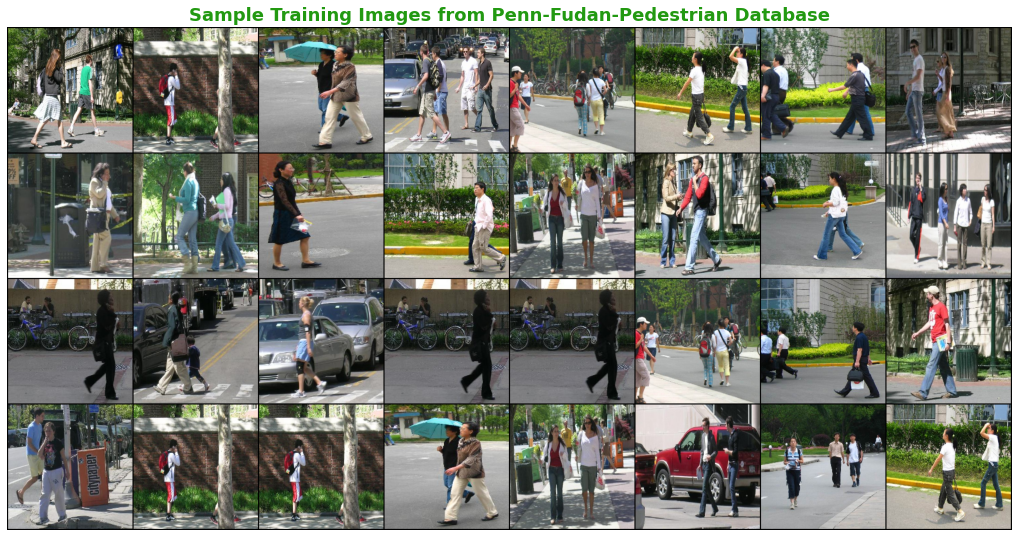

In [6]:
################################################################################################################################
# define datasets and dataloaders of the penn-fudan-database 
# our dataset has two classes only - background and person.
# using custom defined transformations 
# split the dataset in train and test set
# define training and validation data loaders
# and finally display some images from the test dataloader
################################################################################################################################
from engine import train_one_epoch, evaluate
import utils

dataset_tra      = PennFudanDataset('PennFudanPed', get_transform(train=True))

dataset_tes      = PennFudanDataset('PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset_tra)).tolist()

dataset_test = torch.utils.data.Subset(dataset_tes, indices[-50:])
dataset_train = torch.utils.data.Subset(dataset_tra, indices[:-50])

data_loader = torch.utils.data.DataLoader(dataset_train,batch_size=1,shuffle=True,num_workers=0,collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test,batch_size=1,shuffle=True,num_workers=0,
                                               collate_fn=utils.collate_fn)

viz(data_loader_test,num_imgs=32)

In [37]:
################################################################################################################################
# Let’s now write the main function which performs the training and the validation:
# can train on gpu or cpu if gpu not available
# get the model using our helper function
# move model to the right device
# construct an optimizer learning rate scheduler and loss function
# and train it for 2 epochs now. I've already trained for 20 epochs and there's no more improvement possible.
# load the trained weights
# train for one epoch, printing different losses and eta etc for every 10 images 
# update the learning rate
# evaluate on the test dataset
# and then save the model after each epcoh
################################################################################################################################
from tqdm.notebook import tqdm as tqdmTrain
def main():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    num_classes = 91
   
    model = get_model_instance(num_classes)    
    model.to(device)

    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.00005, weight_decay=0.0005) 
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1, gamma=0.95,verbose=1)
    num_epochs = 1
    model = torch.load('./Weights/model_PYTORCH_Object_detection_GIT_79_87.pth')
    for epoch in tqdmTrain(range(num_epochs)):
        
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        
        lr_scheduler.step()
        
        evaluate(model, data_loader_test, device=device)
        torch.save(model, './Weights/model_PYTORCH_Object_detection_GIT.pth')
    

In [68]:
printmd('Trained for total 11 epochs.')

## <span style="color:#116611">Trained for total 11 epochs.</span>

In [38]:
################################################################################################################################
# run the main training fuction
################################################################################################################################
if __name__ == '__main__':
    model=main()


Adjusting learning rate of group 0 to 5.0000e-05.


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [0]  [  0/120]  eta: 0:28:29  lr: 0.000000  loss: 0.4209 (0.4209)  loss_classifier: 0.3141 (0.3141)  loss_box_reg: 0.0936 (0.0936)  loss_objectness: 0.0077 (0.0077)  loss_rpn_box_reg: 0.0054 (0.0054)  time: 14.2432  data: 0.0776
Epoch: [0]  [ 10/120]  eta: 0:20:34  lr: 0.000005  loss: 0.2231 (0.2442)  loss_classifier: 0.1609 (0.1595)  loss_box_reg: 0.0465 (0.0560)  loss_objectness: 0.0181 (0.0246)  loss_rpn_box_reg: 0.0027 (0.0041)  time: 11.2221  data: 0.0689
Epoch: [0]  [ 20/120]  eta: 0:18:57  lr: 0.000009  loss: 0.2628 (0.2662)  loss_classifier: 0.1208 (0.1698)  loss_box_reg: 0.0616 (0.0641)  loss_objectness: 0.0148 (0.0270)  loss_rpn_box_reg: 0.0024 (0.0053)  time: 11.2309  data: 0.0690
Epoch: [0]  [ 30/120]  eta: 0:16:47  lr: 0.000013  loss: 0.2722 (0.2555)  loss_classifier: 0.1208 (0.1573)  loss_box_reg: 0.0737 (0.0656)  loss_objectness: 0.0126 (0.0269)  loss_rpn_box_reg: 0.0029 (0.0057)  time: 11.1824  data: 0.0639
Epoch: [0]  [ 40/120]  eta: 0:15:33  lr: 0.000017  loss:

In [39]:
################################################################################################################################
# load the weights to a model for detections on some video and image files
################################################################################################################################

model = torch.load('./Weights/model_PYTORCH_Object_detection_GIT.pth')


In [40]:
################################################################################################################################
# load coco-names 
################################################################################################################################
def load_classes(path):
    """
    Loads class labels at 'path'
    """
    fp = open(path, "r")
    names = fp.read().split("\n")[:-1]
    return names
path = './coco-names.txt'
COCO_NAMES = load_classes(path)

################################################################################################################################
# define as many as colors as coco-classes or more but not less, and verify that 
################################################################################################################################

def colors():
    colors=[]
    for i in range(1,4):
        for j in range(1,5):
            for k in range(1,9):
                m,n,o=(i*85),(j*35),(k*10)
                if m > 255:  m = 255
                if n > 255:  n = 255
                if o > 255:  o = 255
                if k in [1,3,5,7]: s=(m,n,o)
                elif j in [2,4]:   s=(o,m,n)
                else:              s=(n,o,m)
                colors.append(s)
    colors.reverse()
    return colors
colors = colors()
len(COCO_NAMES),len(colors)

(91, 96)

In [56]:
################################################################################################################################
# to override color of a class of objects of your choice, you can do here by using the index of the class from coco-file
################################################################################################################################
colors[1]=(100,250,100)  # person
colors[6]=(155,20,50)    # bus
#colors[3]=(100,20,219)  # cars
colors[4]=(255,9,19)     # motorbikes
colors[44]=(1,1,200)     # bottle   
colors[33]=(100,100,200)     # bottle   

In [42]:
################################################################################################################################
# define a function for to do predictions on a video frame; prediction should contain class, boxes, scores and index for colors
# and all these only which pass the threshold requirement, plus also take care if there are no objects in image(for any period) 
################################################################################################################################

def get_predictions(frame, threshold,Type='I'):
    ws_flag=0
    try:
        if Type=='I':
            img = Image.open(frame).convert('RGB')
        elif Type=='V':
            img = frame
        else:
            raise ValueError 
    except ValueError: 
        print('Parameter "Type" should be "I" for Image path and "V" for Video frame; other values not allowed ')
        return
    transform = T.Compose([T.ToTensor()])

    img = transform(img,(3,250,250))     
    pred = model([img[0]])
    pred_class  = [COCO_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_colors = [COCO_NAMES.index(i) for i in list(pred_class)]
    pred_boxes  = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    
    pred_score  = list(pred[0]['scores'].detach().numpy())
   
    try:    
        pred_t      = [pred_score.index(x) for x in pred_score if x>threshold][-1]
        
    except IndexError: 
        ws_flag=1

        pred_t=0

    pred_boxes  = pred_boxes[:pred_t+1]
    pred_class  = pred_class[:pred_t+1]
    pred_colors = pred_colors[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    if ws_flag==1:
        threshold=np.round(np.max(pred_score),2)
        
    return pred_boxes, pred_class, pred_colors, pred_score, threshold


In [43]:
################################################################################################################################
# define an Image and video frame detection api, that will get the bounding boxes, class, color index and score. It will also
# print bounding-box, class, score and colors on the frame or an image for all objects
################################################################################################################################

def Video_and_Image_detection_api(frame,output=None, Type='V',  threshold=0.8, rect_th=3,  text_th=3):
      if (Type=='V' or Type=='I'):
          boxes, pred_cls, pred_colors, pred_score, threshold = get_predictions(frame, threshold,Type)
      else:
        print('Please enter the right "Type"; "V" for Video Frame, "I" for Image Path')
        return
      img = frame 
      if Type=='I':
          img = cv2.imread(frame)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      for i in range(len(boxes)):          
            cv2.rectangle(img,(int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]),int(boxes[i][1][1])), \
                          thickness=rect_th,color=colors[pred_colors[i]])
            tsz= int(boxes[i][1][0]) - int(boxes[i][0][0]) ; a = int(tsz/11) ; tsz = tsz*.004
            txt = str(pred_cls[i].title())+' '+str(np.round(pred_score[i],2))
            cv2.rectangle(img,(int(boxes[i][0][0]),int(boxes[i][0][1])), \
                          ((int(boxes[i][0][0])+int(19*len(txt)*tsz)),(int(boxes[i][0][1])-a)), \
                           thickness=-3,color=colors[pred_colors[i]])
            
            cv2.putText(img,txt, (int(boxes[i][0][0]),int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, tsz, \
                          color=(255,255,255),thickness=text_th)
            
      fig=figure(figsize=(16, 8)) 
      if Type=='V':
          title("Video Stream in Progress.... "+str(int((j/(num_frames-1))*100))+'% complete',fontweight='bold',fontsize=14)
          if (j==num_frames-1):
             title("Video Stream is "+str(int((j/(num_frames-1))*100))+'% complete',fontweight='bold',fontsize=14)
      elif Type=='I':
          title(str(i+1)+" Objects detected from this Image with confidence above "+str(np.round(threshold*100,2))+'%'\
               ,fontweight='bold',fontsize=14)
      imshow(img)
      show()
      if output != None:
          img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
          cv2.imwrite(output+str(j)+'.jpg',img)
      clear_output(wait=True)
   

In [69]:
printmd('Image object detection')

## <span style="color:#116611">Image object detection</span>

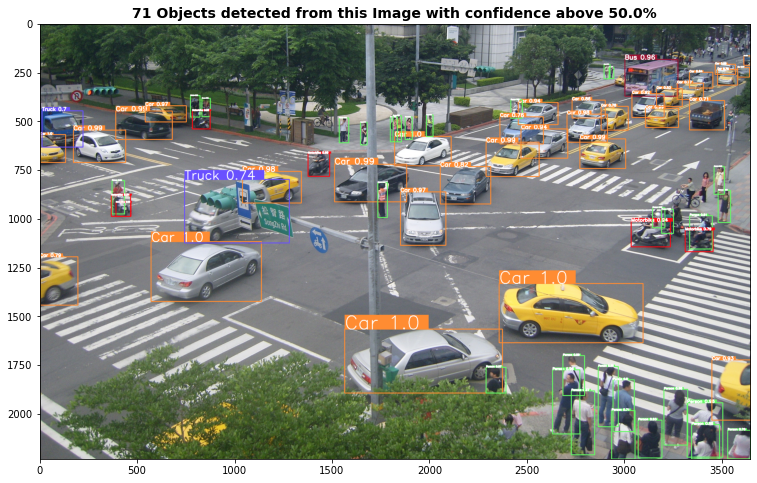

In [44]:
################################################################################################################################
# detections on an Image taken at traffic sign at a busy intersection in the USA
################################################################################################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
frame='Intersection-Counts.jpg'
Video_and_Image_detection_api(frame, Type='I',threshold=0.5)

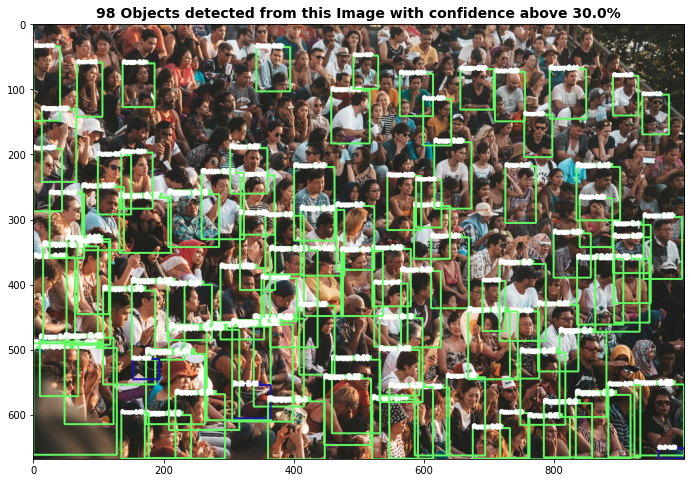

In [45]:
################################################################################################################################
# detections on an image of crowded people. The api can only detect maximum of 100 objects from any image or video frame 
################################################################################################################################
frame='crowded_people.jfif'
Video_and_Image_detection_api(frame, Type='I',threshold=0.3,rect_th=2,text_th=3)

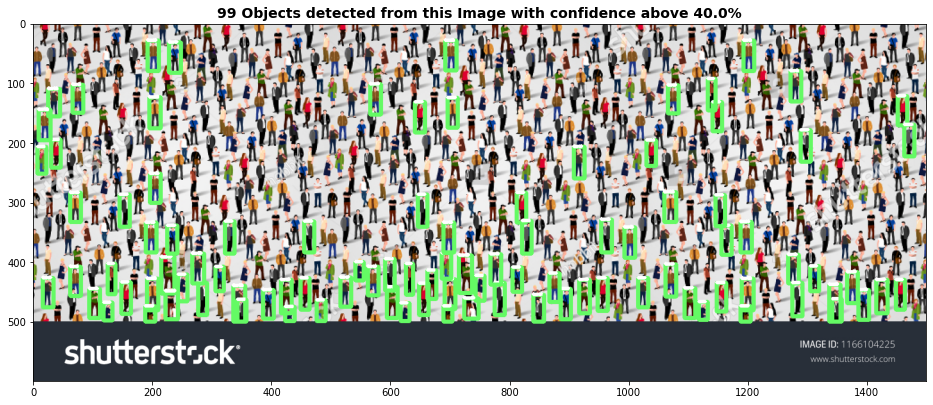

In [46]:
################################################################################################################################
# detections on an image of crowded people. The api can only detect maximum of 100 objects from any image or video frame 
################################################################################################################################
frame='crowded_people2.jpg'
Video_and_Image_detection_api(frame, Type='I',threshold=0.4,rect_th=5,text_th=4)

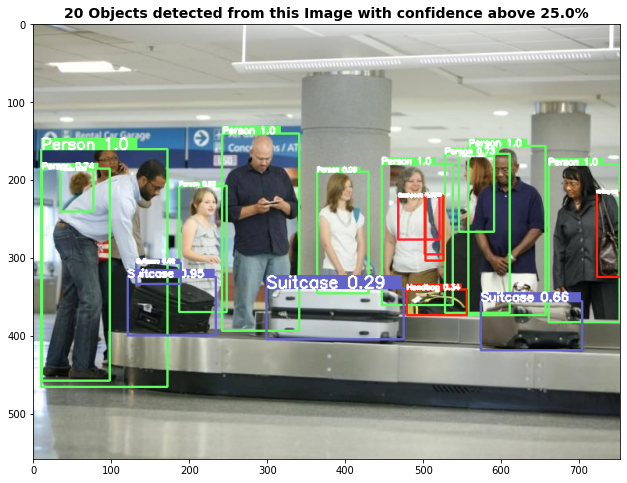

In [58]:
################################################################################################################################
# detections on an image of crowded people. The api can only detect maximum of 100 objects from any image or video frame 
################################################################################################################################
frame='baggage_claim.jpg'
Video_and_Image_detection_api(frame, Type='I',threshold=0.25,rect_th=2,text_th=2)

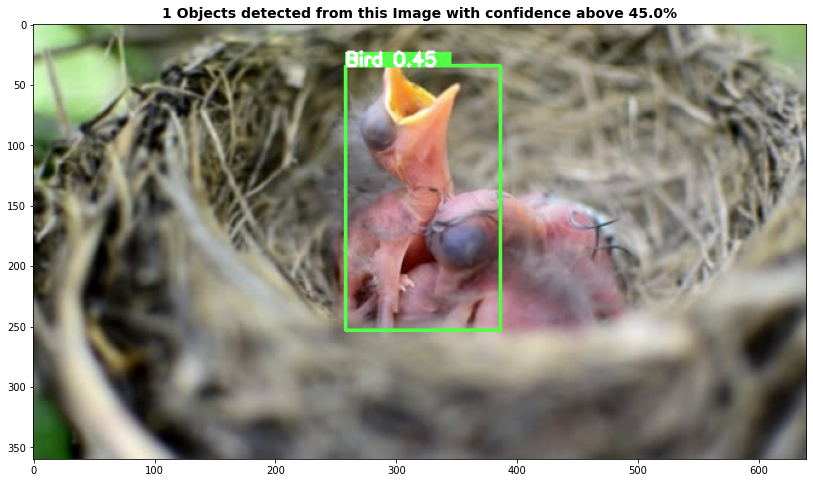

In [48]:
################################################################################################################################
# detections on an image of crowded people. The api can only detect maximum of 100 objects from any image or video frame 
################################################################################################################################
frame='chicks.jpg'
Video_and_Image_detection_api(frame, Type='I',threshold=0.7,rect_th=2,text_th=2)

In [70]:
printmd('Video object detection')

## <span style="color:#116611">Video object detection</span>

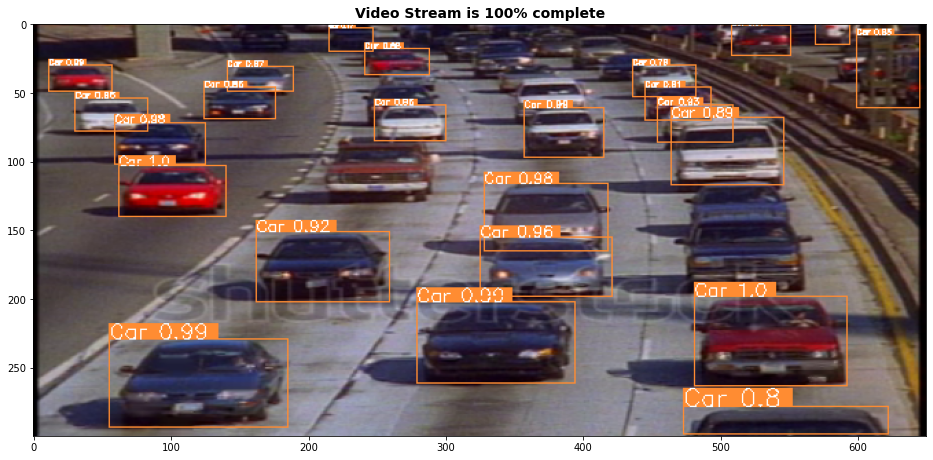

In [49]:
################################################################################################################################
# detections on video file of busy highway. 
################################################################################################################################
num_frames=200
 
videopath = 'freeway-traffic.webm' 

vid = cv2.VideoCapture(videopath)
for j in range(num_frames):
    _, frame = vid.read()    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame,(650,300))
    Video_and_Image_detection_api(frame, threshold=0.75,rect_th=1,text_th=1)

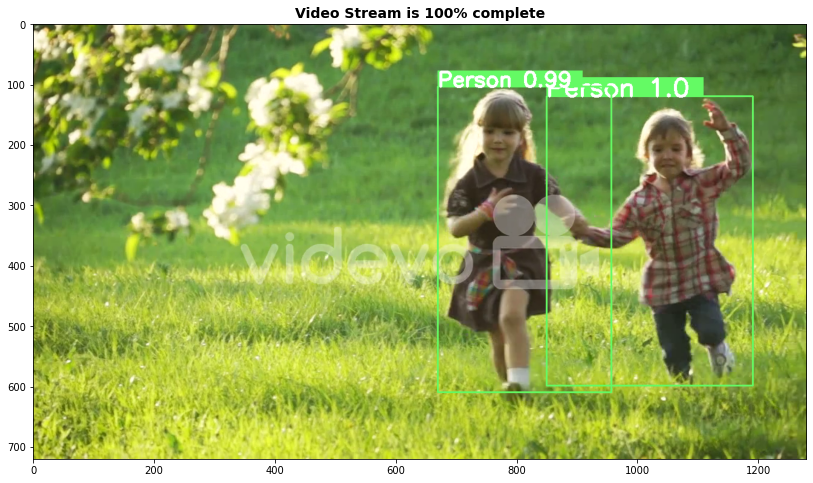

In [50]:
################################################################################################################################
# detections on video file of 2 playing girls
################################################################################################################################
num_frames=60
videopath = 'Two_girls.mp4'
model.eval()
vid = cv2.VideoCapture(videopath)
for j in range(num_frames):
    _, frame = vid.read()    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    Video_and_Image_detection_api(frame, threshold=0.95,rect_th=2,text_th=3)
    

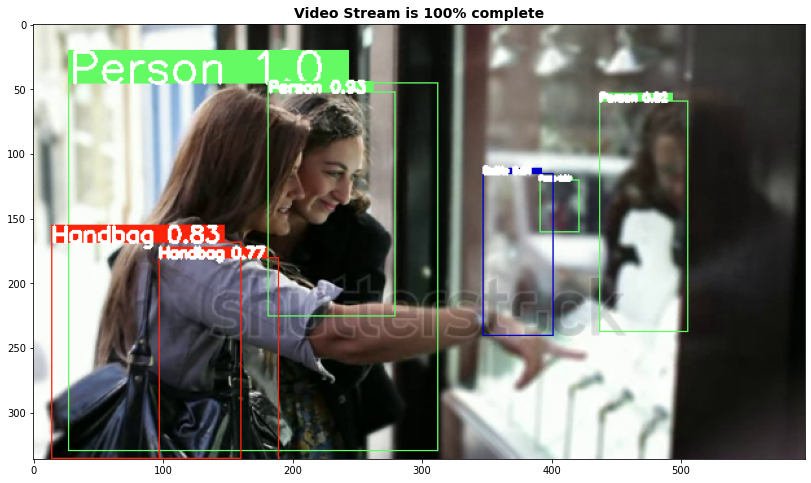

In [51]:
################################################################################################################################
# detectionss on two_women webm file
################################################################################################################################
num_frames=120
videopath = 'Two_women.webm'
model.eval()
vid = cv2.VideoCapture(videopath)
for j in range(num_frames):
    _, frame = vid.read()    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    Video_and_Image_detection_api(frame, threshold=0.75,rect_th=1,text_th=2)

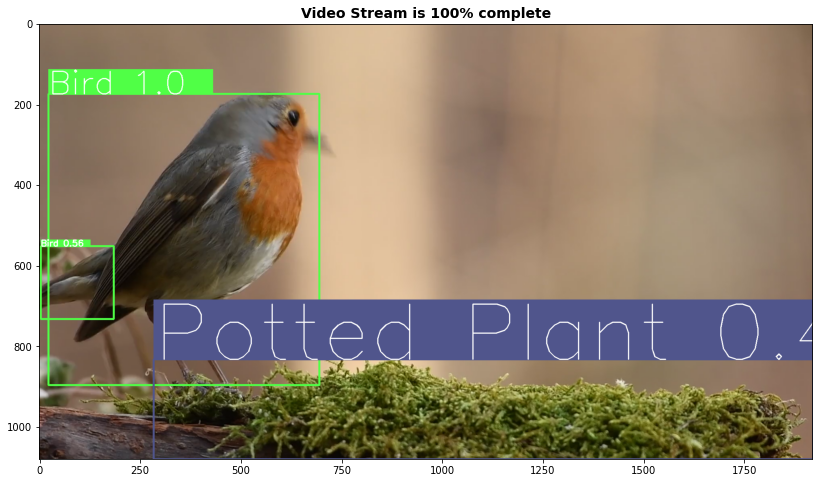

In [52]:
################################################################################################################################
# detections on bird with plotted plat
################################################################################################################################
num_frames=155
videopath = 'Robin.mp4'
vid = cv2.VideoCapture(videopath)
for j in range(num_frames):
    _, frame = vid.read()    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    Video_and_Image_detection_api(frame, threshold=0.29,text_th=2)

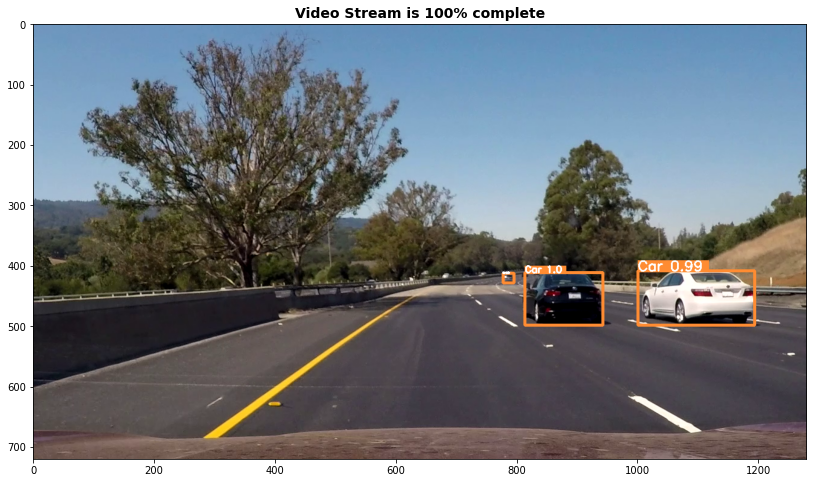

In [53]:
################################################################################################################################
# detections on speeding cars of a US Highway
################################################################################################################################
num_frames=37
videopath = 'cars.mp4'
vid = cv2.VideoCapture(videopath)
for j in range(num_frames):
    _, frame = vid.read()    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    output='./My_cars/my_cars'
    Video_and_Image_detection_api(frame, threshold=0.9,Type='V',text_th=2)
    

# a video file created with the detections from the above execution 

In [ ]:








<video width=856, height=256, controls src="/Videos/myCars.mp4" />

In [ ]:
from IPython.display import HTML
HTML("""
    <video width='556', height='256',alt="myCars" controls>
        <source src="./Videos/myCars.mp4" type="video/mp4">
    </video>
""")

In [ ]:
###############################################################################################################################
# # detections of the above speeding cars in a video file from a jyupiter cell
###############################################################################################################################

from IPython.display import Video

Video("/Videos/myCars.mp4",width=556, height=256)